In [1]:
#SIPaKMeD Veritabanı, Pap smear slaytlarının 966 küme hücre görüntüsünden manuel olarak kırpılmış izole edilmiş hücrelerin 4049 görüntüsünden oluşur. 
#Bu görüntüler, optik mikroskoba uyarlanmış bir CCD kamera aracılığıyla elde edildi. 
#Hücre görüntüleri normal, anormal ve iyi huylu hücreleri içeren beş kategoriye ayrılmıştır.


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.applications import imagenet_utils
import tensorflow
import cv2

from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.vgg19 import VGG19
#from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.applications.efficientnet import EfficientNetB7
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

imgdata = []
imgoutdata = []

labels = []
compressed_img_size = 80
celltypes = ['im_Koilocytotic', 'im_Metaplastic', 'im_Dyskeratotic', 'im_Parabasal', 'im_Superficial-Intermediate']
path = ["../input/cervical-cancer-largest-dataset-sipakmed/" + celltype  + "/" + celltype + "/CROPPED/" for celltype in celltypes]


#Sadece görüntüyü okuma kısmı hazır kod filter kısmını okuduğum makaledeki gibi medyan filter ile değiştirip test etmeyi planlıyorum.

# Low pass filter
#LOW_PASS_FILTER = False
# High pass filter
#HIGH_PASS_FILTER = False

cur_label = -1
for celltype in path:
    cur_label += 1 
    cellimages = os.listdir(celltype)
    for cellimage in cellimages:
        if cellimage.lower().endswith(".bmp"):
            # Mark each cell with a cell type
            labels.append(cur_label)
            img = cv2.imread(celltype+cellimage)
            img = np.array(Image.fromarray(img, 'RGB').resize((compressed_img_size, compressed_img_size)))
            #if LOW_PASS_FILTER:
            #    img = cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT)
            #elif HIGH_PASS_FILTER:
            #    img = img - cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT) + 127
            img_median = cv2.medianBlur(img,5 ) # Add median filter to image
            img_yuv = cv2.cvtColor(img_median, cv2.COLOR_BGR2YUV)

            # equalize the histogram of the Y channel
            img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

            # convert the YUV image back to RGB format
            img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
            
            imgdata.append(img)

            imgoutdata.append(img_output)

labels = np.array(labels)
imgdata = np.array(imgdata)
print(labels,imgdata)


[0 0 0 ... 4 4 4] [[[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [215 172 240]
   [211 170 242]
   [212 174 245]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [214 170 235]
   [212 170 243]
   [218 180 244]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [209 167 229]
   [215 173 243]
   [222 185 244]]

  ...

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]]


 [[[214 196 199]
   [214 195 195]
   [210 194 196]
   ...
   [214 199 206]
   [213 200 203]
   [214 199 201]]

  [[215 197 196]
   [214 195 194]
   [208 195 196]
   ...
   [216 198 207]
   [214 199 204]
   [215 197 203]]

  [[214 197 195]
   [212 194 195]
   [207 192 194]
   ...
   [215 200 204]
   [217 19

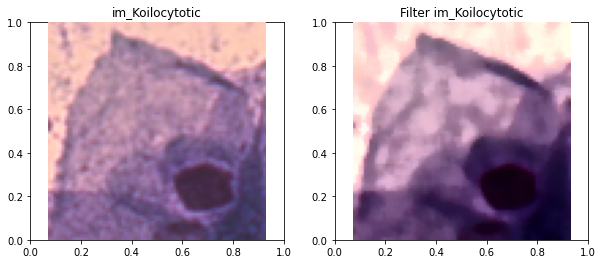

In [2]:
def show_the_image(i):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)
      
    # showing image
    plt.imshow(imgdata[i])
    plt.axis('off')
    plt.title(celltypes[labels[i]])
                       
                       
    fig.add_subplot(rows, columns, 2)
      
    # showing image
    plt.imshow(imgoutdata[i])
    plt.axis('off')
    plt.title("Filter "+celltypes[labels[i]])

    
show_the_image(3)

In [12]:
#https://keras.io/api/applications/ bu linkten modellerin performanslarını inceleyip modelleri seçtim.
#include_top false değerinde sadece özellik çıkarma katmanları modele dahil edildi.Sanırım sorduğunuz soru bu kısımdı.

#model_densenet = DenseNet201(weights = 'imagenet', include_top = False)
#model_nasnet = NASNetMobile(weights = 'imagenet', include_top = False)
#model_mobilenet = MobileNetV2(weights = 'imagenet', include_top = False)
#model_ıncepnet = InceptionResNetV2(weights = 'imagenet', include_top = False)
model_ıncepnet = InceptionV3(weights = 'imagenet', include_top = False)

#model_resnet = ResNet152V2(weights = 'imagenet', include_top = False)
#model_vgg = VGG19(weights = 'imagenet', include_top = False)


#features_nasnet = model_nasnet.predict(imgdata, batch_size=32)
#features_densenet = model_densenet.predict(imgdata, batch_size=32)
#features_mobilenet = model_mobilenet.predict(imgdata, batch_size=32)
features_ıncepnet = model_ıncepnet.predict(imgdata, batch_size=32)
#features_resnet = model_resnet.predict(imgdata, batch_size=32)
#features_vgg = model_vgg.predict(imgdata, batch_size=32)

#print(features_densenet.shape)
#print(features_nasnet.shape)
#print(features_mobilenet.shape)
#print(features_ıncepnet.shape)
#print(features_resnet.shape)
#print(features_vgg.shape)

87924736/87910968 [==============================] - 1s 0us/step


In [13]:
#Normalde diğer modeller ile birleştiriyorum. Test ederken birleştirmeden denemişim en son.

extracted_features = []

for f_d , label in zip(features_ıncepnet,labels):
    f_d = f_d.reshape(f_d.shape[0] * f_d.shape[1] * f_d.shape[2])    
    f_d = np.append(f_d, label)
    extracted_features.append(f_d)
    
extracted_features = np.array(extracted_features)

print(extracted_features.shape)

(4049, 2049)


In [14]:
# # Normalization :-

X = extracted_features[:, 0:-1]
y = extracted_features[:, -1]

In [15]:

# Feature Scaling (Özellik Ölçeklendirme)
###################
# StandardScaler: Klasik standartlaştırma. Ortalamayı çıkar, standart sapmaya böl. z = (x - u) / s
###################
ss = StandardScaler()
ss = ss.fit_transform(X)

# RobustScaler: Medyanı çıkar iqr'a böl.
###################
rs = RobustScaler()
rs = rs.fit_transform(X)
###################

# MinMaxScaler: Verilen 2 değer arasında değişken dönüşümü
###################

# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min

mms = MinMaxScaler()
mms = mms.fit_transform(X)

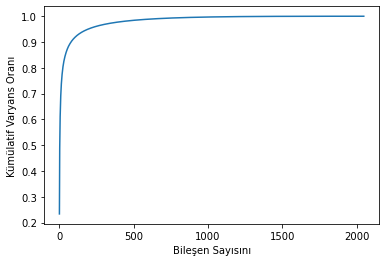

array([0.23337829, 0.42241156, 0.48850219, 0.54140363, 0.57932232,
       0.61097474, 0.634278  , 0.6560285 , 0.6763107 , 0.69182666,
       0.705852  , 0.7176961 , 0.72774392, 0.73772235, 0.74606503,
       0.75360116, 0.76104055, 0.76809239, 0.77442257, 0.78010651,
       0.78550179, 0.79073914, 0.79569529, 0.80012999, 0.80448238,
       0.80846696, 0.81231067, 0.81594743, 0.81935395, 0.82245076,
       0.82539964, 0.82827503, 0.83098719, 0.83365819, 0.83622535,
       0.83874924, 0.84121477, 0.84354983, 0.8457825 , 0.84796264,
       0.85007657, 0.85212885, 0.85413219, 0.85609951, 0.8579781 ,
       0.85979967, 0.86158792, 0.86329715, 0.8649601 , 0.86660461,
       0.86817482, 0.86972469, 0.87123991, 0.87273325, 0.87419114,
       0.87558625, 0.87696148, 0.87826494, 0.87955612, 0.88082611,
       0.8820446 , 0.88323503, 0.88438474, 0.88552142, 0.88661936,
       0.88769891, 0.88877158, 0.88982574, 0.8908476 , 0.89184525,
       0.89281768, 0.89378109, 0.89472814, 0.89564536, 0.89655

In [16]:
# Optimum Bileşen Sayısı
################################

pca = PCA().fit(mms)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Bileşen Sayısını")
plt.ylabel("Kümülatif Varyans Oranı")
plt.show()

################################
# Final PCA'in Oluşturulması
################################
pca = PCA(n_components=0.97) #tabloya göre belirledim.
X = pca.fit_transform(mms)

pca.explained_variance_ratio_
np.cumsum(pca.explained_variance_ratio_)


In [17]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [18]:
# Optimum parametre seçimi
######################################################

knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}


classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(eval_metric='logloss'), xgboost_params),
               ('LightGBM', lgb.LGBMClassifier(), lightgbm_params),
               ('LR', LogisticRegression()),
                ("SVC", SVC()),
                ('Adaboost', AdaBoostClassifier()),
                ('GBM', GradientBoostingClassifier())]

In [19]:
def hyperparameter_optimization(X, y, cv=3, scoring="accuracy"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(sorted(cv_results.keys()))
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")

        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models



def main():
    best_models = hyperparameter_optimization(X, y)

main()

Hyperparameter Optimization....
########## KNN ##########
['fit_time', 'score_time', 'test_score']
accuracy (After): 0.6762
KNN best params: {'n_neighbors': 10}

########## CART ##########
['fit_time', 'score_time', 'test_score']
accuracy (After): 0.594
CART best params: {'max_depth': 6, 'min_samples_split': 23}

########## RF ##########
['fit_time', 'score_time', 'test_score']
accuracy (After): 0.7214
RF best params: {'max_depth': None, 'max_features': 'auto', 'min_samples_split': 20, 'n_estimators': 300}

########## XGBoost ##########
['fit_time', 'score_time', 'test_score']
accuracy (After): 0.7392
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}

########## LightGBM ##########
['fit_time', 'score_time', 'test_score']
accuracy (After): 0.7545
LightGBM best params: {'learning_rate': 0.1, 'n_estimators': 500}



ValueError: not enough values to unpack (expected 3, got 2)